In [1]:
!pip install torchinfo
!nvidia-smi

Wed Jul 31 11:28:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             12W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# import

import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torchinfo
import os
from pytz import timezone
from tqdm import tqdm

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)  # 출력결과: cuda 
print('Count of using GPUs:', torch.cuda.device_count())
print('Current cuda device:', torch.cuda.current_device())

Device: cuda
Count of using GPUs: 2
Current cuda device: 0


In [16]:
# 하이퍼파라미터 설정
RANDOM_SEED = 4242
LEARNING_RATE = 0.0001
BATCH_SIZE = 45
EPOCHS = 25
IMG_SIZE = 227
NUM_CLASSES = 10

# 규제화 파라미터 설정
DROPOUT = 0.5
LRN_K = 2.0
LRN_ALPHA = 0.0001
LRN_BETA = 0.75
LRN_N = 5

In [17]:
# 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            probabilities = F.softmax(model(images), dim=-1)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [18]:
# 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [19]:
# 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [20]:
# 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [21]:
def training_loop(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):
    train_losses = []
    valid_losses = []
    print(
        datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
        "--- Start Training Loop ---",
    )

    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # validation
        model.eval()
        running_loss = 0.0
        valid_loader_tqdm = tqdm(valid_loader, desc=f"Validation {epoch + 1}/{epochs}", leave=False)
        with torch.no_grad():
            for inputs, labels in valid_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
        
        valid_loss = running_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch + 1}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [22]:
# AlexNet 현대적으로 재해석한 책에서 제시된 버전으로 구현 (multi-GPU 구현하지 않음, 배치정규화 차용)
class ModernAlexNet(nn.Module):
    def __init__(self):
        super(ModernAlexNet, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.dropout = nn.Dropout(DROPOUT)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(384)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(256)
        self.fc6 = nn.Linear(6 * 6 * 256, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, NUM_CLASSES)

    def forward(self, x):
        # Conv 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.batchnorm1(x)
        # Conv 2
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.batchnorm2(x)
        # Conv 3
        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        # Conv 4
        x = F.relu(self.conv4(x))
        x = self.batchnorm4(x)
        # Conv 5
        x = F.relu(self.conv5(x))
        x = self.batchnorm5(x)
        x = self.pool(x)
        # FC 6
        x = x.view(-1, 6 * 6 * 256)
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        # FC 7
        x = F.relu(self.fc7(x))
        x = self.dropout(x)
        # FC 8
        logits = self.fc8(x)
        return logits

torchinfo.summary(
    ModernAlexNet(),
    input_size=(1, 3, IMG_SIZE, IMG_SIZE),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    row_settings=["depth", "var_names"],
)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ModernAlexNet (ModernAlexNet)            [1, 3, 227, 227]          [1, 10]                   --                        --
├─Conv2d (conv1): 1-1                    [1, 3, 227, 227]          [1, 96, 55, 55]           34,944                    [11, 11]
├─MaxPool2d (pool): 1-2                  [1, 96, 55, 55]           [1, 96, 27, 27]           --                        3
├─BatchNorm2d (batchnorm1): 1-3          [1, 96, 27, 27]           [1, 96, 27, 27]           192                       --
├─Conv2d (conv2): 1-4                    [1, 96, 27, 27]           [1, 256, 27, 27]          614,656                   [5, 5]
├─MaxPool2d (pool): 1-5                  [1, 256, 27, 27]          [1, 256, 13, 13]          --                        3
├─BatchNorm2d (batchnorm2): 1-6          [1, 256, 13, 13]          [1, 256, 13, 13]          512                       --
├─Conv

Files already downloaded and verified


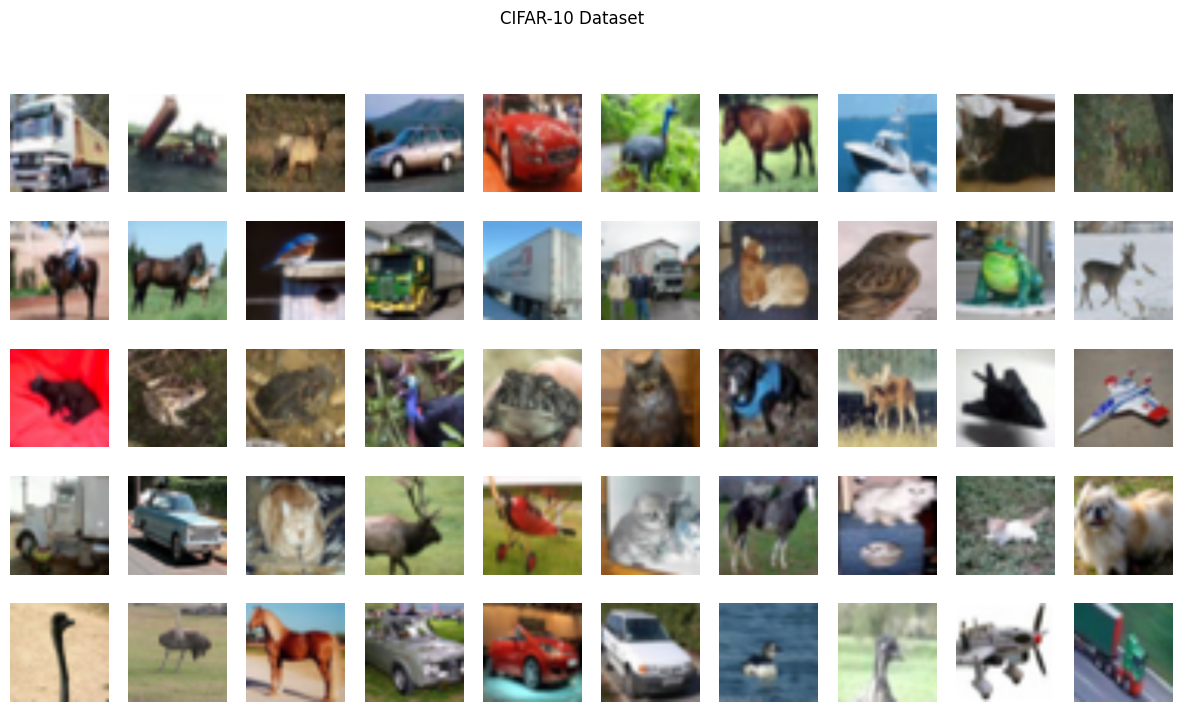

train dataset size:  42000
valid dataset size:  9000
test dataset size:  9000


In [23]:
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 뒤집기
        transforms.ToTensor(),
    ]
)

# 데이터셋 다운로드 및 생성
full_dataset = datasets.CIFAR10(root="cifar10_data", train=True, transform=transform, download=True)
full_dataset = ConcatDataset([full_dataset, datasets.CIFAR10(root="cifar10_data", train=False, transform=transform)])

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size = total_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

# 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# 불러온 CIFAR-10 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(15, 8))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis("off")
    img = train_dataset.dataset[index][0]
    img = img.permute(1, 2, 0)  # (채널, 높이, 너비) -> (높이, 너비, 채널)
    plt.imshow(img)

fig.suptitle("CIFAR-10 Dataset")
plt.show()

# 데이터셋 크기 출력
print("train dataset size: ", len(train_dataset))
print("valid dataset size: ", len(valid_dataset))
print("test dataset size: ", len(test_dataset))


20:32:56 --- Start Training Loop ---


20:35:00 ---  Epoch: 1	Train loss: 1.3149	Valid loss: 1.2850	Train accuracy: 55.51	Valid accuracy: 55.04


20:37:04 ---  Epoch: 2	Train loss: 0.9001	Valid loss: 0.8661	Train accuracy: 70.62	Valid accuracy: 69.76


20:39:09 ---  Epoch: 3	Train loss: 0.7412	Valid loss: 0.7553	Train accuracy: 76.04	Valid accuracy: 74.14


20:41:13 ---  Epoch: 4	Train loss: 0.6417	Valid loss: 0.6604	Train accuracy: 79.88	Valid accuracy: 77.23


20:43:17 ---  Epoch: 5	Train loss: 0.5580	Valid loss: 0.5175	Train accuracy: 85.34	Valid accuracy: 82.08


20:45:22 ---  Epoch: 6	Train loss: 0.4951	Valid loss: 0.5089	Train accuracy: 86.84	Valid accuracy: 82.48


20:47:27 ---  Epoch: 7	Train loss: 0.4334	Valid loss: 0.5343	Train accuracy: 87.23	Valid accuracy: 81.56


20:49:31 ---  Epoch: 8	Train loss: 0.3885	Valid loss: 0.4961	Train accuracy: 89.79	Valid accuracy: 83.24


20:51:35 ---  Epoch: 9	Train loss: 0.3381	Valid loss: 0.4426	Train accuracy: 92.93	Valid accuracy: 85.17


20:53:39 ---  Epoch: 10	Train loss: 0.2959	Valid loss: 0.4230	Train accuracy: 93.77	Valid accuracy: 85.42


20:55:43 ---  Epoch: 11	Train loss: 0.2692	Valid loss: 0.4396	Train accuracy: 94.61	Valid accuracy: 85.77


20:57:47 ---  Epoch: 12	Train loss: 0.2390	Valid loss: 0.4277	Train accuracy: 95.84	Valid accuracy: 85.71


20:59:51 ---  Epoch: 13	Train loss: 0.2084	Valid loss: 0.4167	Train accuracy: 97.10	Valid accuracy: 86.74


21:01:56 ---  Epoch: 14	Train loss: 0.1890	Valid loss: 0.4936	Train accuracy: 95.14	Valid accuracy: 84.41


21:04:01 ---  Epoch: 15	Train loss: 0.1784	Valid loss: 0.4647	Train accuracy: 96.99	Valid accuracy: 86.23


21:06:06 ---  Epoch: 16	Train loss: 0.1596	Valid loss: 0.4580	Train accuracy: 97.79	Valid accuracy: 86.48


21:08:11 ---  Epoch: 17	Train loss: 0.1447	Valid loss: 0.4894	Train accuracy: 97.36	Valid accuracy: 86.22


21:10:15 ---  Epoch: 18	Train loss: 0.1411	Valid loss: 0.4570	Train accuracy: 98.35	Valid accuracy: 86.99


21:12:19 ---  Epoch: 19	Train loss: 0.1296	Valid loss: 0.4835	Train accuracy: 98.35	Valid accuracy: 86.41


21:14:22 ---  Epoch: 20	Train loss: 0.1287	Valid loss: 0.4540	Train accuracy: 98.74	Valid accuracy: 86.98


21:16:27 ---  Epoch: 21	Train loss: 0.1179	Valid loss: 0.4959	Train accuracy: 98.71	Valid accuracy: 87.40


21:18:31 ---  Epoch: 22	Train loss: 0.1103	Valid loss: 0.5101	Train accuracy: 98.60	Valid accuracy: 86.83


21:20:36 ---  Epoch: 23	Train loss: 0.1047	Valid loss: 0.4928	Train accuracy: 99.19	Valid accuracy: 87.47


21:22:40 ---  Epoch: 24	Train loss: 0.0968	Valid loss: 0.5429	Train accuracy: 98.95	Valid accuracy: 86.49


21:24:44 ---  Epoch: 25	Train loss: 0.1020	Valid loss: 0.5296	Train accuracy: 99.00	Valid accuracy: 87.16


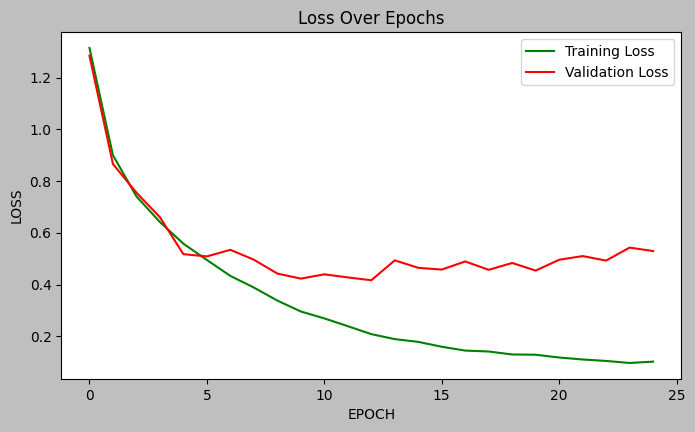

In [24]:
torch.manual_seed(RANDOM_SEED)

model = ModernAlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, EPOCHS, DEVICE
)

Test Loss: 0.5721, Test Accuracy: 0.8650


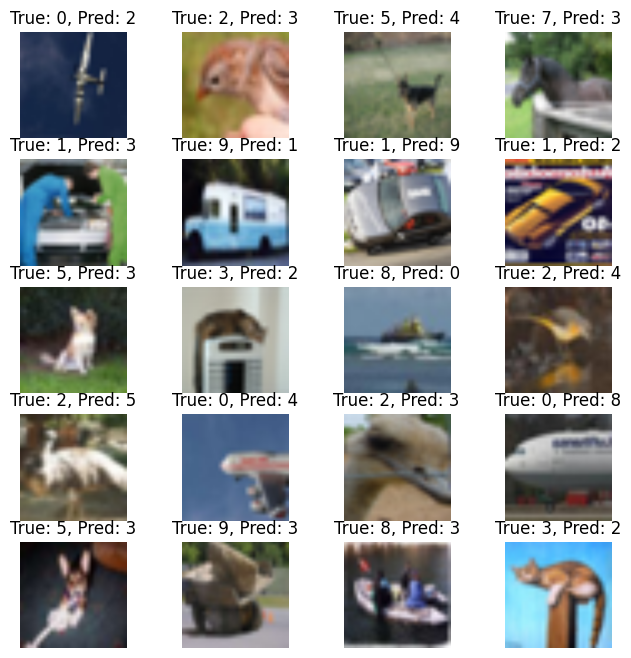

In [29]:
import matplotlib.pyplot as plt

# 테스트 데이터셋을 사용하여 모델의 성능을 평가하고 틀린 예시를 저장
def test_and_collect_mistakes(test_loader, model, criterion, device):
    model.eval()  # 평가 모드로 전환
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    mistakes = []

    with torch.no_grad():  # 평가시에는 그래디언트 계산 불필요
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 순전파와 손실 기록하기
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)

            # 예측 및 정확도 계산
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 틀린 예시 저장
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    mistakes.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))

    epoch_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / total

    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return epoch_loss, accuracy, all_preds, all_labels, mistakes

# 모델 학습이 완료된 후 평가 수행
test_loss, test_accuracy, test_preds, test_labels, mistakes = test_and_collect_mistakes(test_loader, model, criterion, DEVICE)

# 틀린 예시 시각화
def plot_mistakes(mistakes, num_examples=20):
    plt.figure(figsize=(8, 8))
    for i, (image, true_label, pred_label) in enumerate(mistakes[:num_examples]):
        plt.subplot(5, 4, i + 1)
        plt.axis('off')
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.show()
    
# 틀린 예시 출력
plot_mistakes(mistakes)
